# Test for explantion4tsc

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import string
from sklearn import metrics
from datetime import date

import matplotlib.pyplot as plt
from sktime.classification.shapelet_based import MrSEQLClassifier
from sklearn.linear_model import RidgeClassifierCV
from pyts.transformation import WEASEL
from sklearn.metrics import accuracy_score

from scripts.Noise import Noise
from scripts.Explanation import GetExplanation, reshape_lime_explanation, load_explanation, create_random_explanation
import utils.visualization as vis
from utils.data import LocalDataLoader, data_summary
from scripts.Experiment import Evaluate
from scripts.CompareExplanation import CompareExplanation

%load_ext autoreload
%autoreload 2

Dataset: CMJ
X_train.shape:  (419, 1, 500)
X_test.shape:  (179, 1, 500)
Unique target class:  ['0', '1', '2']
Dataset: CMJ, Training Data-Global mean value: 36.99815


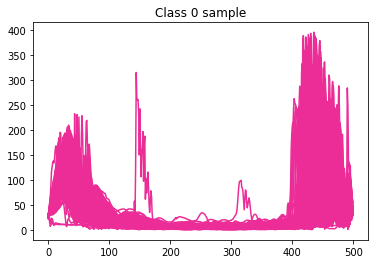

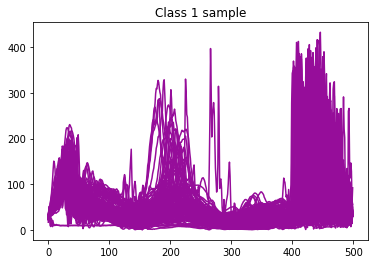

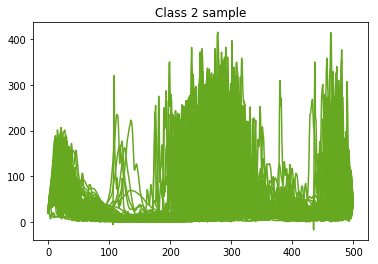

In [2]:
# ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_list = [
#     'TwoPatterns',
    'CMJ'
#     'Meat', 'Strawberry','OliveOil'
    #     'SmallMiddle_CAR','RareTime_NARMA',
#            'Moving_RareTime_CAR', 'Moving_RareTime_PseudoPeriodic', 'Moving_RareTime_Harmonic', 'PostionalFeature_Harmonic','PostionalFeature_PseudoPeriodic'
]
ds_dir = 'data'

for ds in ds_list:
    data_summary(ds_dir,ds)

In [12]:
# MRSEQL accuracy
for ds in ds_list:
    print(ds)
    data = LocalDataLoader(datapath=ds_dir,dataset=ds)
    X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)
    model = MrSEQLClassifier(seql_mode="fs")
    model.fit(X_train,y_train)
    preds = model.predict(X_test)

    print('MrSEQL Accuracy on %s dataset: ' %ds, accuracy_score(y_test,preds))
    print('----------------')

CMJ


C:\Users\trang\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: FutureWarning: Call to deprecated class MrSEQLClassifier. (MrSEQLClassifier will be removed in v0.10.0. It will be replaced with an implementation based on Numba.) -- Deprecated since version 0.8.1.
  
C:\Users\trang\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: FutureWarning: Call to deprecated class SEQLCLF. (SEQLCLF will be removed in v0.10.0) -- Deprecated since version 0.8.1.
  


MrSEQL Accuracy on CMJ dataset:  0.9608938547486033
----------------


## Explain

Given a dataset (datapath + dataset name), provide an explanation by a method. Output is a 2D array of explanation weights for univariate time series

C:\Users\trang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


(179, 10)


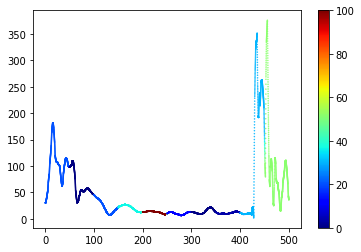

In [4]:
# Explain by Mr-SEQL (need update for other XAIs method)
# Provide an explanation method, a X/y train/test data.
# Explanation is provided for X_test 
# exp_weight is an 2d array (univariate, shape (n,:))
exp_list = [
    'rocket']
for ds in ds_list:
    for explanation_type in exp_list:
        data = LocalDataLoader(ds_dir,ds)
        X_train,y_train,X_test,y_test = data.get_X_y()
        exp = GetExplanation(datapath=ds_dir, dataset=ds, explanation_type=explanation_type)
        exp_weights = exp.explanation_weight
        print(exp_weights.shape)
        if explanation_type in ['lime', 'rocket']:
            reshaped_exp_weights = reshape_lime_explanation(ds_dir,ds,exp_weights)
        else:
            reshaped_exp_weights = exp_weights
        vis.visualize_explanation(idx=18,X_series=X_test,explanation=reshaped_exp_weights,ds=ds) 

        filename =  "exp_weights/weights_%s_%s.txt" %(explanation_type.upper(),ds)
        np.savetxt(filename, exp_weights, delimiter=',')

### Perturb

In [7]:
if ds in ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']:
    xais = ['LIME', 'MrSEQL', 'Resnet','GradientShap','IG','ROCKET'] 
    explanation_names =[ 'lime_mrseql', 'mrseql', 'cam','GS','IG','lime_rocket']
else:
    xais = ['LIME', 'MrSEQL','GradientShap','IG','ROCKET'] 
    explanation_names =[ 'lime_mrseql', 'mrseql','GS','IG','lime_rocket']

assert len(xais) == len(explanation_names)
random_seeds = [2020]
lime_xais = ['lime','LIME','Lime','ROCKET']

explanation_list = []
for xai in xais:
    is_reshape=True if xai in lime_xais else False
    weight = load_explanation(datapath=ds_dir,dataset=ds,explanation_type=xai,reshape_lime=is_reshape)
    explanation_list.append(weight)

print('Explanation Shape: ', explanation_list[0].shape)
print('Total numbers of XAI Methods: ', len(explanation_list))
print('Names of XAI Methods: ', explanation_names)


Explanation Shape:  (179, 500)
Total numbers of XAI Methods:  6
Names of XAI Methods:  ['lime_mrseql', 'mrseql', 'cam', 'GS', 'IG', 'lime_rocket']


In [14]:
exp_weights = explanation_list[1]
print(exp_weights.shape)

(179, 500)


(179, 1, 500)


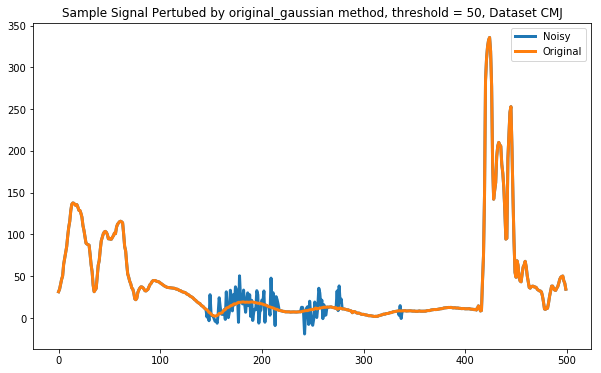

In [15]:
# Perturb based on an XAI method#
# Note that after adding noise, there will be function will return X_perturbed in 2d array
# X_test is an 2d array or an expanded 2d array in 2nd dim (n,1,:)
# weight is 2d array (n,:)

data = LocalDataLoader(datapath=ds_dir,dataset=ds)
X_train,y_train,X_test,y_test =data.get_X_y(onehot_label=False)


noise = Noise(X=X_test,explanation=exp_weights, noise_type='original_gaussian')

noise.add_noise(threshold=20)
X_perturbed = noise.X_perturbed_3d 
print(X_perturbed.shape)
noise.visualize(idx =10,threshold=50,dataset_name=ds)


In [ ]:
noise.add_noise(threshold=50)
noise.visualize(idx =10,threshold=50,dataset_name=ds)

(179, 1, 500)


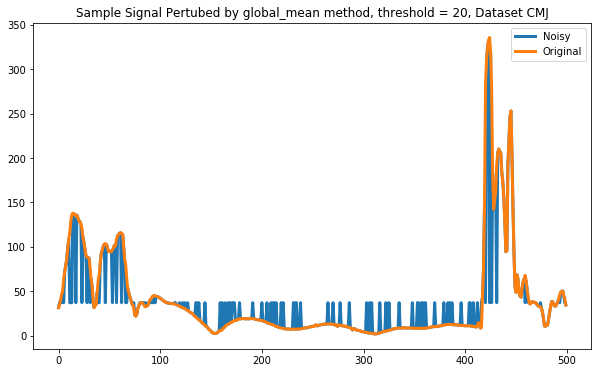

In [13]:
# Random explanation
random_weights = np.squeeze(np.random.uniform(0,100,size=X_test.shape))
# Perturb base on random exp
random_noise = Noise(X=X_test,explanation=random_weights, 
                     noise_type='global_mean')

random_noise.add_noise(threshold=20)
X_perturbed_random = random_noise.X_perturbed_3d
print(X_perturbed_random.shape)
random_noise.visualize(idx =10,threshold=20,dataset_name=ds)

## Visualize

In [26]:
ds_list = [
#     'Beef',
 'Car',
 'CBF',
 'Coffee',
 'CricketX',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'GunPoint',
 'Ham',
 'Haptics',
 'ItalyPowerDemand',
 'Meat',
 'MoteStrain',
 'OliveOil',
 'Plane',
 'SonyAIBORobotSurface1',
 'SonyAIBORobotSurface2',
 'Strawberry',
 'Trace',
 'TwoLeadECG',
 'TwoPatterns',
 'UWaveGestureLibraryZ',
 'Wafer',
 'Wine',
 'WormsTwoClass',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'PowerCons']
import glob

In [30]:

for ds in ds_list:
    if ds not in ['Beef','Ham','OliveOil','Wine']:
        print(ds)
        path = glob.glob('./exp_weights/weights_ROCKET_%s*.txt'%(ds))[0]
    

Car
CBF
Coffee
CricketX
ECG200
ECG5000
ECGFiveDays
GunPoint
Haptics
ItalyPowerDemand
Meat
MoteStrain
Plane
SonyAIBORobotSurface1
SonyAIBORobotSurface2
Strawberry
Trace
TwoLeadECG
TwoPatterns
UWaveGestureLibraryZ
Wafer
WormsTwoClass
GunPointAgeSpan
GunPointMaleVersusFemale
GunPointOldVersusYoung
PowerCons


In [18]:
ds='ECG200'
path = glob.glob('./exp_weights/weights_ROCKET_%s*.txt'%(ds))

In [19]:
path

['./exp_weights\\weights_ROCKET_ECG200.txt']